In [24]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

Sklearn **make_moons dataset** at this [link](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html#sklearn.datasets.make_moons)

In [25]:
X, y = datasets.make_moons(n_samples=10000, noise=0.4)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [27]:
from sklearn.ensemble import RandomForestClassifier

In [28]:
from sklearn.ensemble import VotingClassifier

In [29]:
from sklearn.linear_model import LogisticRegression

In [30]:
from sklearn.svm import SVC

In [31]:
log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

In [32]:
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')

In [33]:
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomF...,
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [34]:
from sklearn.metrics import accuracy_score

In [35]:
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.8296
RandomForestClassifier 0.834
SVC 0.8572
VotingClassifier 0.8516


### Bagging and Pasting

One way to get a diverse set of classifiers is to use very different training algorithms, as just discussed. Another approach is to use the same training algorithm for every predictor, but to train them on different random subsets of the training set. When sampling is performed:
- *with replacement*, this method is called **bagging** (short for *bootstrap aggregating*). 
- *without replacement*, it is called **pasting**.

Nói cách khác cả *bagging* và *pasting* đều cho phép các "training instances" được sampled vài lần với các predictors khác nhau, nhưng chỉ có *bagging* là cho phép "training instances" được sampled vài lần với cùng 1 predictors. 

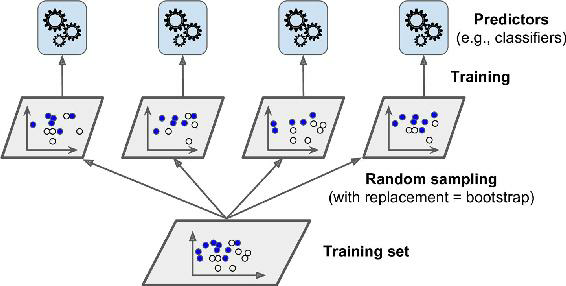

Ở hình trên, các predictors đều có thể được train song song, thông qua các CPU core khác nhau hoặc ở các server khác nhau. Tương tự, predictions có thể được tao ra song song. Điều này là một trong những lý do giải thích *bagging* và *pasting* lại là những phương pháp được dùng phổ biến: những phương pháp này có thể mở rộng rất tốt.

### Bagging và Pasting trong Scikit-Learn

Đoạn code dưới đây train một ensemble của 500 Decision Tree Classifier, mỗi một Classifier train trên một 100 training instance được sampled ngẫu nhiên từ training set với "replacememnt". Đây là một ví dụ cho *bagging*, nhưng nếu cần cho *pasting*, chỉ cần đặt `bootstrap=False`.

Tham số `n_jobs` để chỉ cho Sciki-Learn số lượng CPU core dùng cho training và predictions (nếu bằng `-1` nghĩa là Sciki-Learn sử dụng toàn bộ core sẵn có).

In [36]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [37]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(),
            n_estimators=500,
            max_samples=100,
            bootstrap=True,
            n_jobs=-1)

In [38]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [40]:
y_pred = bag_clf.predict(X_test)

In [41]:
y_pred

array([0, 1, 0, ..., 1, 1, 1], dtype=int64)

Bootstrapping introduces a bit more diversity in the subsets that each predictor is trained on, so bagging ends up with a slightly higher bias than pasting, but this also means that predictors end up being less correlated so the ensemble’s variance is reduced. Overall, bagging often results in better models, which explains why it is generally preferred. However, if you have spare time and CPU power you can use cross-validation to evaluate both bagging and pasting and select the one that works best.

### Out-of-Bag Evaluation

Với *bagging*, một vài instances có thể được sampled vài lần cho một predictor nào đó, trong khi có những instances khác không hề được gọi tên. 

Mặc định thì *BaggingClassifier* sẽ sample `m` training instance với *replacement* (`bootstrap=True`), với `m` là kích thước của training set. 

Điều này có nghĩa là trung bình chỉ có khoảng 63% số training instance được sample cho mỗi predictor. 37% còn lại không được sample, được gọi là *out-of-bag(oob)* instance. Chú ý là số obb này không giống hệt nhau ở các predictor.

Since a predictor never sees the oob instances during training, it can be evaluated on these instances, without the need for a separate validation set or cross-validation. You can evaluate the ensemble itself by averaging out the oob evaluations of each predictor.

In Scikit-Learn, you can set `oob_score=True` when creating a *BaggingClassifier* to request an automatic oob evaluation after training. The following code demonstrates this. The resulting evaluation score is available through the `oob_score_` variable:

In [42]:
bag_clf = BaggingClassifier(
            DecisionTreeClassifier(), 
            n_estimators=500,
            bootstrap=True,
            n_jobs=-1,
            oob_score=True
)

In [43]:
bag_clf.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=True,
         random_state=None, verbose=0, warm_start=False)

In [44]:
bag_clf.oob_score_

0.8389333333333333

According to this oob evaluation, this BaggingClassifier is likely to achieve about 93.1% accuracy on the test set.

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
y_pred = bag_clf.predict(X_test)

In [47]:
accuracy_score(y_test, y_pred)

0.842

### Random Patches and Random Subspaces

### Random Forests

**Random Forest** là một ensemble của các Decsion Trees, thường được trained với *bagging* method (hoặc đôi lúc *pasting*), đặc biệt với `max_samples` đặt bằng kích thước của training set. 

Thay vì xây một *BaggingClassifier* và truyền cho nó một *DecisionTreeClassifier*, ta có thể sử dụng *RandomForestClassifier* vốn tiện hơn và được tối ưu hơn cho Decision Tree

Đoạn code sau train một Random Forest classifier với 500 tree (mỗi tree giới hạn tối đa 16 node), sử dụng tất cả các CPU core

In [48]:
from sklearn.ensemble import RandomForestClassifier

In [51]:
rnd_clf = RandomForestClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1)

In [52]:
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
y_pred_rf = rnd_clf.predict(X_test)

*Chú ý*:

- With a few exceptions, a RandomForestClassifier has all the hyperparameters of a DecisionTreeClassifier (to control how trees are grown), plus all the hyperparameters of a BaggingClassifier to control the ensemble itself.

### Feature Importance

In [54]:
from sklearn.datasets import load_iris

In [55]:
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.08595294024135963
sepal width (cm) 0.021558580369542904
petal length (cm) 0.43377041287208407
petal width (cm) 0.4587180665170133


### Boosting

**Boosting** (originally called hypothesis boosting) refers to **any Ensemble method** that can **combine several weak learners into a strong learner**. The general idea of most boosting methods is to train predictors sequentially, each trying to correct its predecessor. 

There are many boosting methods available, but by far the most popular ar:
- **AdaBoost13** (short for Adaptive Boosting) and 
- **Gradient Boosting**

### AdaBoost

### Gradient Boosting

Gradient Boosting works by sequentially adding predictors to an ensemble, each one correcting its predecessor. However, instead of tweaking the instance weights at every iteration like AdaBoost does, this method tries to fit the new predictor to the residual errors made by the previous predictor.

In [56]:
from sklearn.tree import DecisionTreeRegressor

In [57]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [58]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [59]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [62]:
y_pred = sum(tree.predict(X) for tree in (tree_reg1, tree_reg2, tree_reg3))

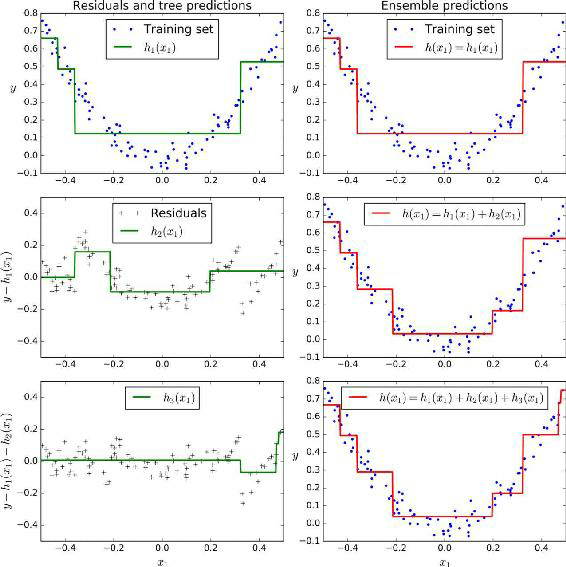

Figure above represents:
- in the left column: the predictions of these three trees, and
- in the right column: the ensemble’s predictions.

In the first row, the ensemble has just one tree, so its predictions are exactly the same as the first tree’s predictions. 

In the second row, a new tree is trained on the residual errors of the first tree. On the right you can see that the ensemble’s predictions are equal to the sum of the predictions of the first two trees. 

Similarly, in the third row another tree is trained on the residual errors of the second tree. You can see that the ensemble’s predictions gradually get better as trees are added to the ensemble.

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

In [64]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)

In [65]:
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)